## Time-Series Data on Germany Energy Consumption
I found this dataset on [Kaggle](https://www.kaggle.com/jordansiem/open-power-systems-data), original file available on GitHub as well (see below).  
In this notebook, a descriptive analysis and some Modelling with the [Facebook-Prophet](https://facebook.github.io/prophet/) package is done.

This dataset contains columns about:
* Date yyyy-mm-dd format
* Electric Consumption
* Wind power production
* Solar power production
* Wind+Solar production SUM

Questions to be answered:
* When is electricity consumption typically highest and lowest?
* How do wind and solar power production vary with seasons of the year?
* What are the long-term trends in electricity consumption, solar power, and wind power?
* How do wind and solar power production compare with electricity consumption, and how has this ratio changed over time?
* Can we properly predict the next years of energy consumption?

In [2]:
import numpy as np
import pandas as pd
import matplotlib

#Allows further customization:
import matplotlib.dates as mdates

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Needed later
import fbprophet as fb

In [3]:
#Import dataset
data = pd.read_csv('https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv'
                   , parse_dates = ['Date'])

In [5]:
data.head() #data has Nas

,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.184,NaN,NaN,NaN
1,2006-01-02,1380.521,NaN,NaN,NaN
2,2006-01-03,1442.533,NaN,NaN,NaN
3,2006-01-04,1457.217,NaN,NaN,NaN
4,2006-01-05,1477.131,NaN,NaN,NaN


In [6]:
data.dtypes

Date           datetime64[ns]
Consumption           float64
Wind                  float64
Solar                 float64
Wind+Solar            float64
dtype: object

In [7]:
#Helper function giving me overview of missing data
def miss_vals_tbl (df):
        zero_vals = (df == 0.00).astype(int).sum(axis=0)
        mis_vals = df.isnull().sum()
        mis_vals_percent = 100 * df.isnull().sum() / len(df)
        duplicates = df.duplicated().sum()
        tbl = pd.concat([zero_vals, mis_vals, mis_vals_percent], axis=1)
        tbl = tbl.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        tbl['Data Type'] = df.dtypes
        tbl = tbl[
            tbl.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("""The dataframe has {} columns and {} rows.\nThere are {} columns that have missing values.\nThe dataframe has {} duplicates."""
               .format(str(df.shape[1]), str(df.shape[0]), str(tbl.shape[0]), duplicates))
        return tbl

In [8]:
miss_vals_tbl(data)

The dataframe has 5 columns and 4383 rows.
There are 3 columns that have missing values.
The dataframe has 0 duplicates.


,Zero Values,Missing Values,% of Total Values,Data Type
Wind+Solar,0,2196,50.1,float64
Solar,0,2195,50.1,float64
Wind,0,1463,33.4,float64


In [9]:
###BAD IDEA### Shows not so good in plot - other imputation methods needed

#Impute NAs with the mean
#data['Wind'].fillna(data['Wind'].median(), inplace = True)
#data['Solar'].fillna(data['Solar'].median(), inplace = True)
#data['Wind+Solar'].fillna(data['Wind+Solar'].median(), inplace = True)

In [10]:
#Put the date as the new index
data.set_index('Date', inplace = True) #when passing data['Date']; column stays in df additionally

In [11]:
#Create new features based on the index
data['year'] = data.index.year
data['month'] = data.index.month
data['weekday'] = data.index.day_name()

#Display a random sample of 5 rows:
data.sample(5, random_state = 0)

,Consumption,Wind,Solar,Wind+Solar,year,month,weekday
Date,,,,,,,
2008-08-23,1152.011,NaN,NaN,NaN,2008,8,Saturday
2013-08-08,1291.984,79.666,93.371,173.037,2013,8,Thursday
2009-08-27,1281.057,NaN,NaN,NaN,2009,8,Thursday
2015-10-02,1391.050,81.229,160.641,241.870,2015,10,Friday
2009-06-02,1201.522,NaN,NaN,NaN,2009,6,Tuesday


#### Visualizing our Data

In [12]:
#Set standard figsize for sns plots, due to the TS formats
sns.set(rc={'figure.figsize':(11,4)})

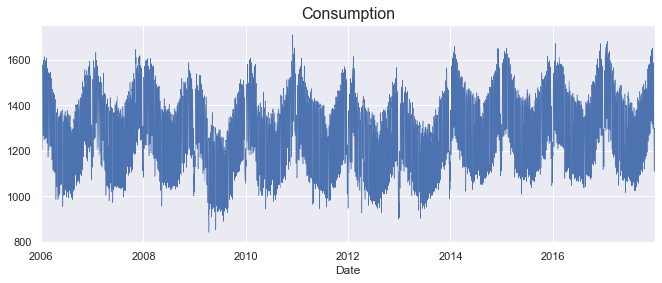

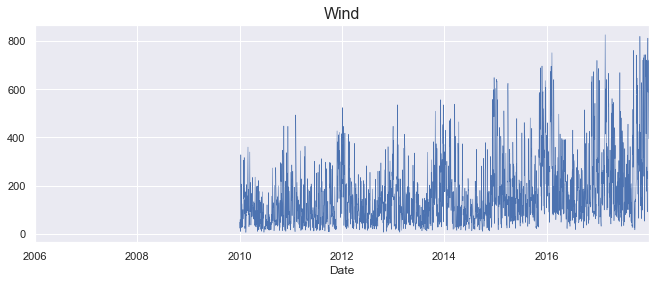

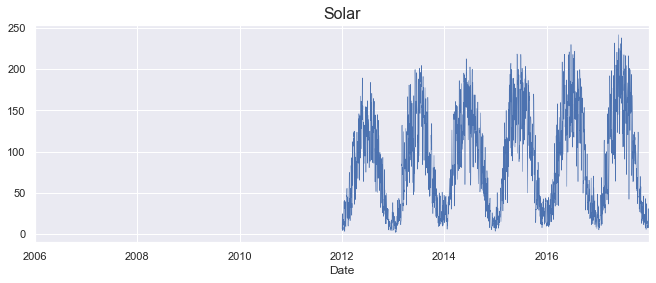

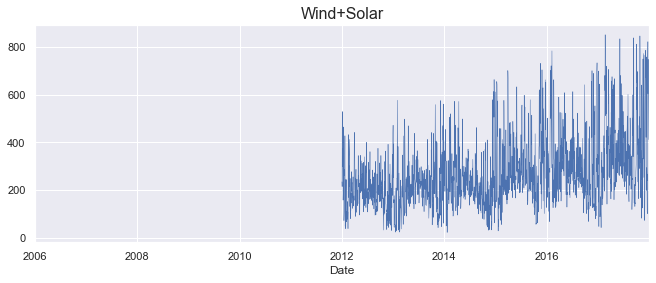

In [13]:
cols = ['Consumption', 'Wind', 'Solar', 'Wind+Solar']

for col in cols:
    data[col].plot(linewidth = 0.5).set_title(col, fontsize = 16)
    plt.show()

Consumption shows a cycle / seasonality, Wind a trend, seasonality is unclear, Solar shows seasonality (summer months) and a little trend. For more in depth analysis, dot-plots are more helpful

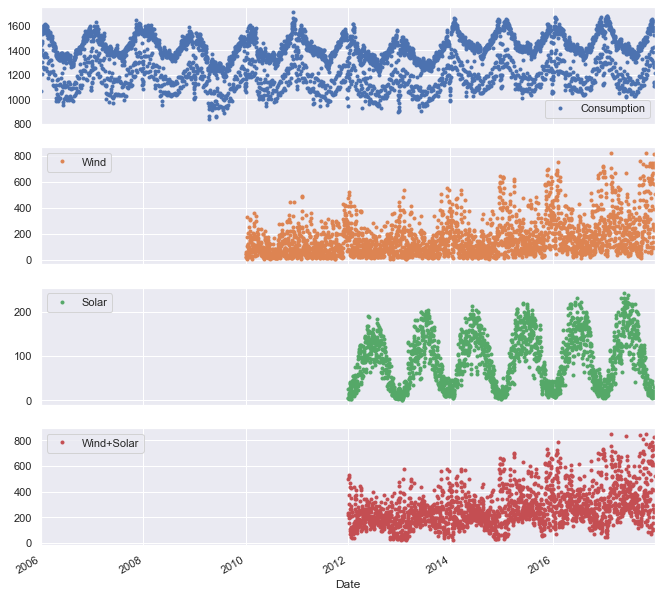

In [14]:
#Different way of making multiple plots of same style
data[cols].plot(marker = '.', figsize = (11, 11), linestyle = 'None', subplots = True);

What we can see as well is that power consumption splits into higher and lower cluster, presumably weekends and weekdays.  
Wind appears to be higher in Winter months - Solar in summer. Further, Wind production increases over the years (trend) but has not such a strong seasonality as Solar.

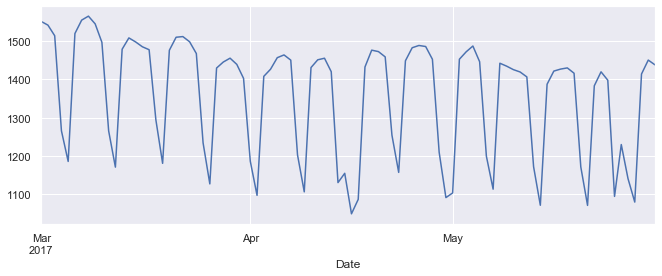

In [15]:
#Have a look at consumption in an interval of 2months.
data.loc['2017-03':'2017-05']['Consumption'].plot()

#Clearly visible, that weekdays spike due to increased power consumption.

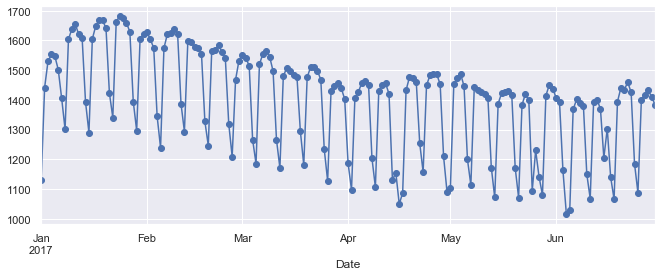

In [16]:
#But does the consumption actually decrease in certain months?
data.loc['2017-01':'2017-06', 'Consumption'].plot(marker = 'o')

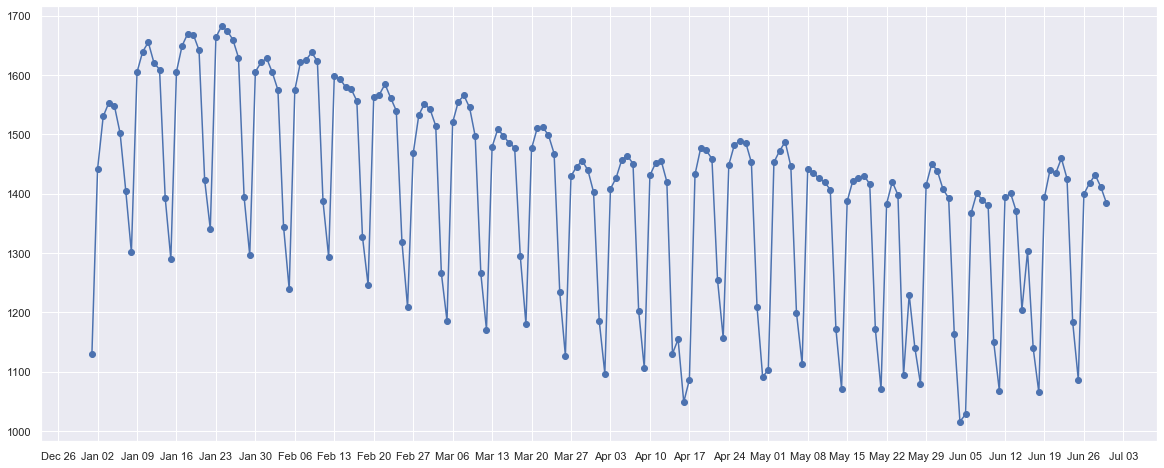

In [17]:
fig, ax = plt.subplots(figsize = (20, 8))

ax.plot(data.loc['2017-01':'2017-06', 'Consumption'], marker = 'o')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

#### Seasonality with Box-Plots

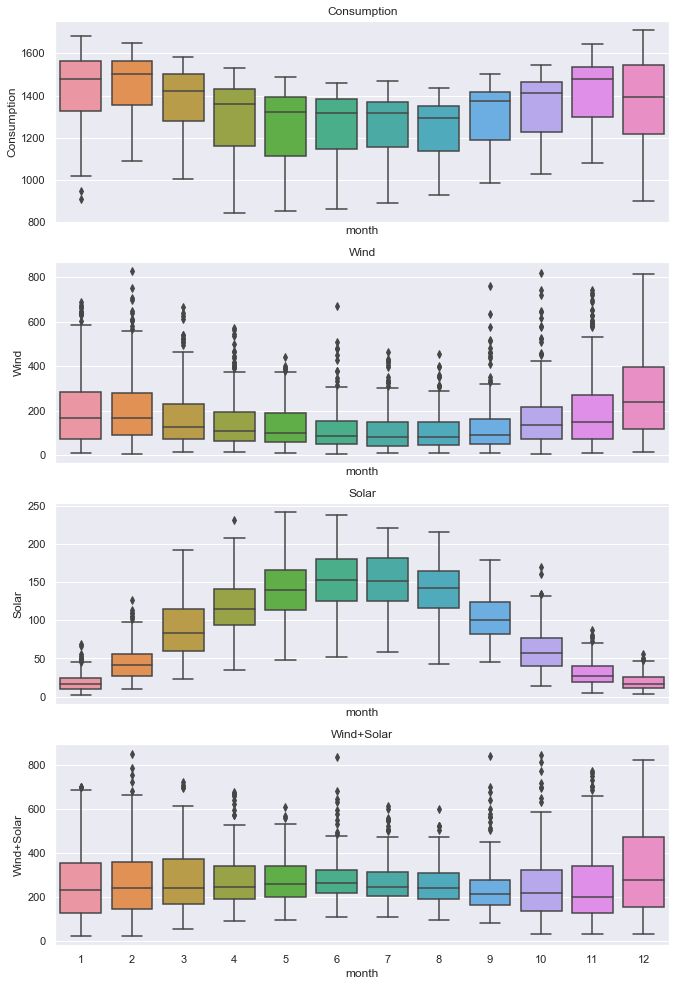

In [18]:
#Monthly Seasonality
fig, axes = plt.subplots(4, 1, figsize = (11, 17), sharex = True)

for col, ax in zip(cols, axes):
    sns.boxplot(data = data, x = 'month', y = col, ax = ax)
    ax.set_title(col)
plt.show()

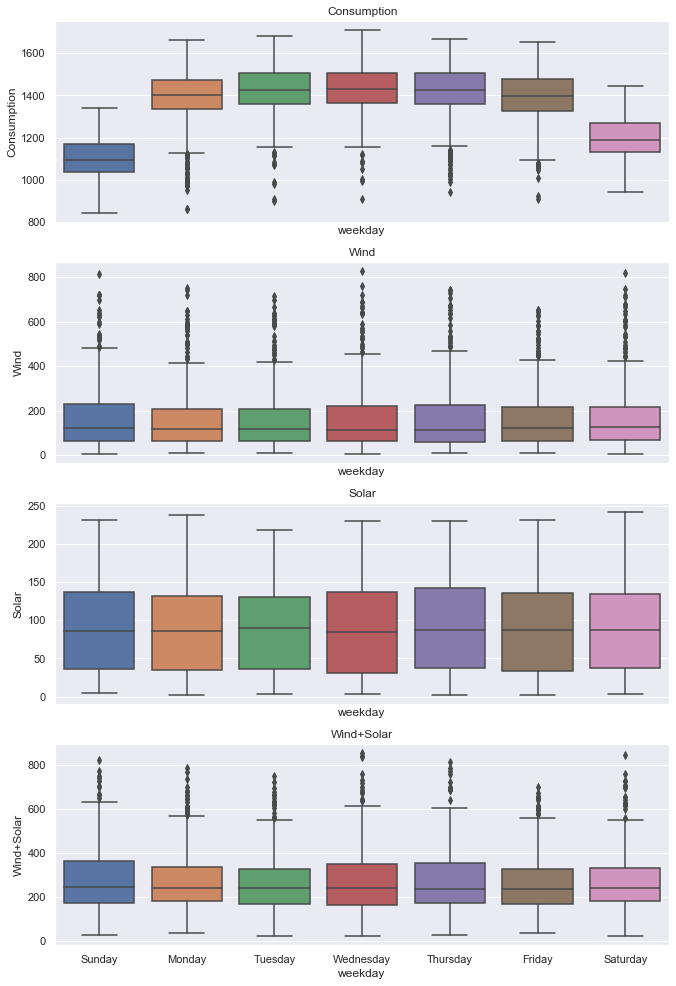

In [19]:
#Weekly Seasonality
fig, axes = plt.subplots(4, 1, figsize = (11, 17), sharex = True)

for col, ax in zip(cols, axes):
    sns.boxplot(data = data, x = 'weekday', y = col, ax = ax)
    ax.set_title(col)
plt.show()

### Frequencies

In [20]:
data.index #shows no frequency

DatetimeIndex(['2006-01-01', '2006-01-02', '2006-01-03', '2006-01-04',
               '2006-01-05', '2006-01-06', '2006-01-07', '2006-01-08',
               '2006-01-09', '2006-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', length=4383, freq=None)

In [21]:
#Data is daily, so lets add daily frequency
#If freq is not strictly daily, new rows with NAs would have been added, not in this case though
data.index.freq = 'D'
data.index

DatetimeIndex(['2006-01-01', '2006-01-02', '2006-01-03', '2006-01-04',
               '2006-01-05', '2006-01-06', '2006-01-07', '2006-01-08',
               '2006-01-09', '2006-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', length=4383, freq='D')

### Resampling

= sampling the data to a higher or lower frequency

In [22]:
#Weekly mean
cols = ['Consumption', 'Wind', 'Solar', 'Wind+Solar']

data_w_mean = data[cols].resample('W').mean()

In [23]:
data_w_mean.tail() #weekly mean

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2017-12-03,1536.236314,284.334286,18.320857,302.655143
2017-12-10,1554.824946,636.514714,16.440286,652.955000
2017-12-17,1543.856889,442.531857,18.143714,460.675571
2017-12-24,1440.342401,339.018429,9.895143,348.913571
2017-12-31,1203.265211,604.699143,19.240143,623.939286


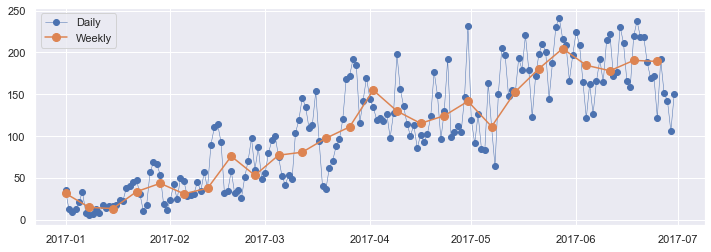

In [24]:
#Let's compare daily and weekly Solar Energy in a plot
#take 6months frame
fig, ax = plt.subplots(figsize = (12, 4))
ax.plot(data.loc['2017-01':'2017-06', 'Solar']
        , marker = 'o'
        , linewidth =0.5
        , label = 'Daily')
ax.plot(data_w_mean.loc['2017-01':'2017-06', 'Solar']
        , marker = 'o'
        , markersize = 8
        , label = 'Weekly')
ax.legend()

Weekly mean is smoother because spikes of consumption have been averaged out.

In [25]:
#Let's add consumptuion up to a monthly basis and plot it with Wind and Solar production
data_m = data[cols].resample('M').sum(min_count = 28) #this min counter keeps the NaNs
data_m.head()

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-31,45304.704,NaN,NaN,NaN
2006-02-28,41078.993,NaN,NaN,NaN
2006-03-31,43978.124,NaN,NaN,NaN
2006-04-30,38251.767,NaN,NaN,NaN
2006-05-31,38858.143,NaN,NaN,NaN


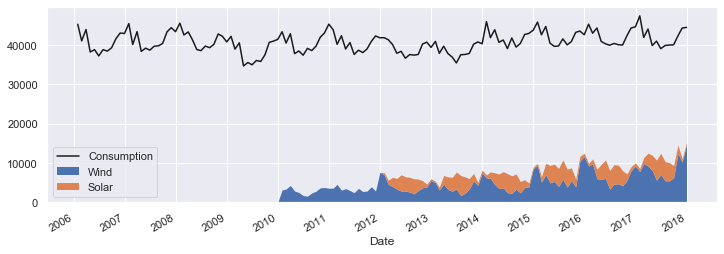

In [26]:
fig, ax = plt.subplots(figsize = (12, 4))

ax.plot(data_m['Consumption'], color = 'k', label = 'Consumption')
data_m[['Wind', 'Solar']].plot.area(ax = ax, linewidth = 0)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.legend()

Yearly Seasonality is clearly visible. Consumptuon is fairly stable, Wind and Solar tends to increase over the years (Trend).

In [27]:
#Let's do yearly resampling
data_y = data[cols].resample('Y').sum(min_count = 50)
data_y.head()

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-12-31,489068.536,NaN,NaN,NaN
2007-12-31,496631.847,NaN,NaN,NaN
2008-12-31,495570.876,NaN,NaN,NaN
2009-12-31,459737.428,NaN,NaN,NaN
2010-12-31,488588.700,35911.777,NaN,NaN


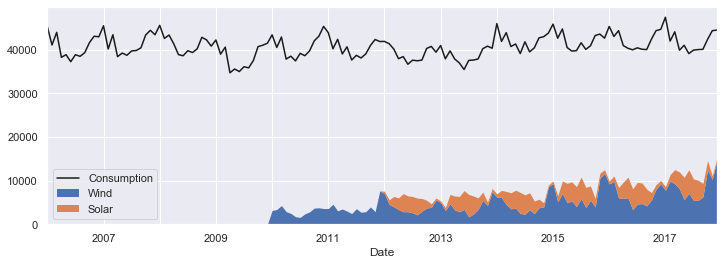

In [28]:
fig, ax = plt.subplots(figsize = (12, 4))

data_m['Consumption'].plot(ax = ax, label = 'Consumption', color = 'k')
data_m[['Wind', 'Solar']].plot.area(ax = ax, linewidth = 0)
ax.grid(which = 'minor')
ax.legend()

### Rolling Windows
= splitting data in windows, data is aggregated, overlap and roll along the same freq

In [29]:
data_w_roll = data[cols].rolling(7, center = True).mean() #center gives the center day of the week
data_w_roll.head()
#First free are NaNs, because 04-01 is the center day of the first week. From there on,
# the rolling mean per week is calculated

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,NaN,NaN,NaN,NaN
2006-01-02,NaN,NaN,NaN,NaN
2006-01-03,NaN,NaN,NaN,NaN
2006-01-04,1361.471429,NaN,NaN,NaN
2006-01-05,1381.300143,NaN,NaN,NaN


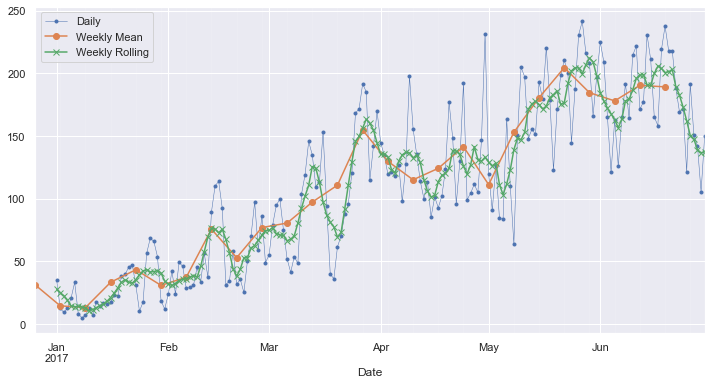

In [32]:
#create 6M window:
start, end = '2017-01', '2017-06'

fig, ax = plt.subplots(figsize = (12, 6))
data.loc[start:end, 'Solar'].plot(marker = '.', linewidth = 0.5, label = 'Daily')
data_w_mean.loc[start:end, 'Solar'].plot(marker = 'o', label = 'Weekly Mean')
data_w_roll.loc[start:end, 'Solar'].plot(marker = 'x', label = 'Weekly Rolling')
ax.grid(which = 'minor', alpha = 0.1)
ax.legend()


### Trends
can be visualized with rolling means at different time scales

In [33]:
#Try a 365 day rolling mean
data_365 = data[cols].rolling(window = 365, center = True, min_periods = 360).median()
#min_periods isolates missing values

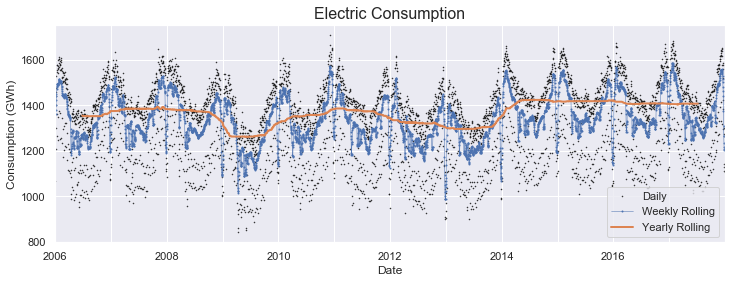

In [34]:
fig, ax = plt.subplots(figsize = (12, 4))

data['Consumption'].plot(marker = '.', label = 'Daily', color = 'k', linestyle = 'None', markersize = 1)
data_w_roll['Consumption'].plot(marker = 'o', label = 'Weekly Rolling', linewidth = 0.5, markersize = 1)
data_365['Consumption'].plot(label = 'Yearly Rolling', linewidth = 2)
ax.grid(which = 'minor')
ax.set_ylabel('Consumption (GWh)')
ax.set_title('Electric Consumption', fontsize = 16)
ax.legend()

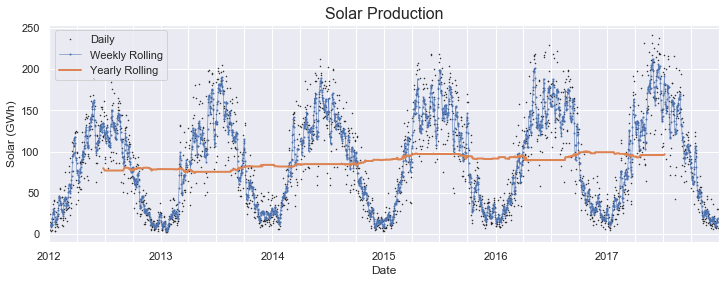

In [35]:
fig, ax = plt.subplots(figsize = (12, 4))

data.loc['2012':,'Solar'].plot(marker = '.', label = 'Daily', color = 'k', linestyle = 'None', markersize = 1)
data_w_roll.loc['2012':,'Solar'].plot(marker = 'o', label = 'Weekly Rolling', linewidth = 0.5, markersize = 1)
data_365.loc['2012':,'Solar'].plot(label = 'Yearly Rolling', linewidth = 2)
ax.grid(which = 'minor')
ax.set_ylabel('Solar (GWh)')
ax.set_title('Solar Production', fontsize = 16)
ax.legend()

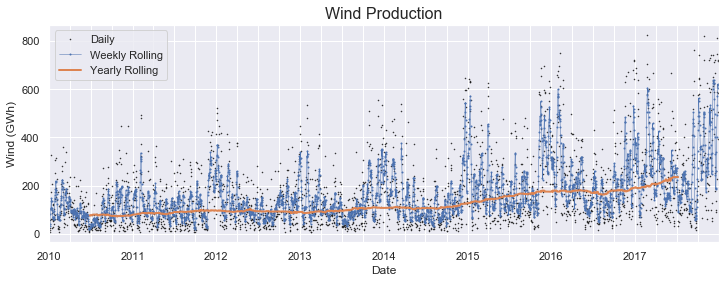

In [36]:
fig, ax = plt.subplots(figsize = (12, 4))

data.loc['2010':,'Wind'].plot(marker = '.', label = 'Daily', color = 'k', linestyle = 'None', markersize = 1)
data_w_roll.loc['2010':,'Wind'].plot(marker = 'o', label = 'Weekly Rolling', linewidth = 0.5, markersize = 1)
data_365.loc['2010':,'Wind'].plot(label = 'Yearly Rolling', linewidth = 2)
ax.grid(which = 'minor')
ax.set_ylabel('Wind (GWh)')
ax.set_title('Wind Production', fontsize = 16)
ax.legend()
#Strong trend from 2017 onwards

(0, 350)

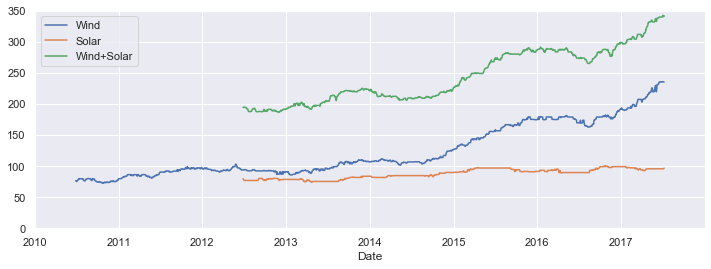

In [37]:
#Comparing the trends of all productions
fig, ax = plt.subplots(figsize = (12, 4))

data_365.loc['2010':,['Wind', 'Solar', 'Wind+Solar']].plot(ax = ax)
ax.set_ylim(0, 350)

Wind shows the biggest trend. Solar less

## Applying Facebook's Prophet Package to predict Energy Consumption

In [38]:
#put date index back as column
fb_data = data['Consumption'].reset_index()

In [39]:
fb_data.rename(columns={'Date' : 'ds', 'Consumption' : 'y'}, inplace = True)

In [40]:
fb_data.head()

,ds,y
0,2006-01-01,1069.184
1,2006-01-02,1380.521
2,2006-01-03,1442.533
3,2006-01-04,1457.217
4,2006-01-05,1477.131


In [44]:
#Make fbprophet model
model = fb.Prophet()

In [45]:
model.fit(fb_data)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [46]:
#Lets create a future df in which we store our predictions
forecast_param = model.make_future_dataframe(periods = 365 * 2, freq = 'D')

forecast = model.predict(forecast_param)

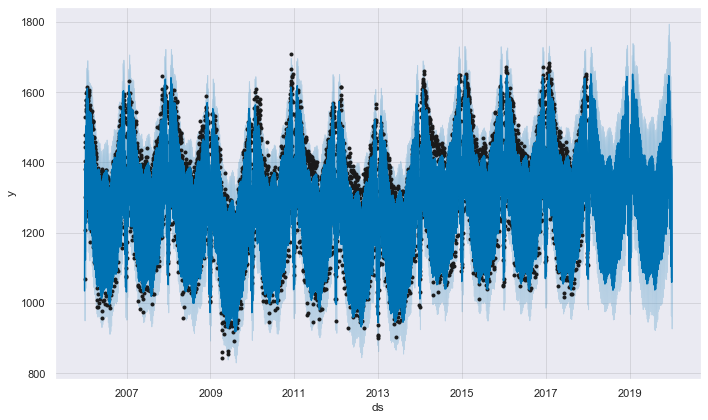

In [47]:
# Forecast of 2 years
model.plot(forecast);

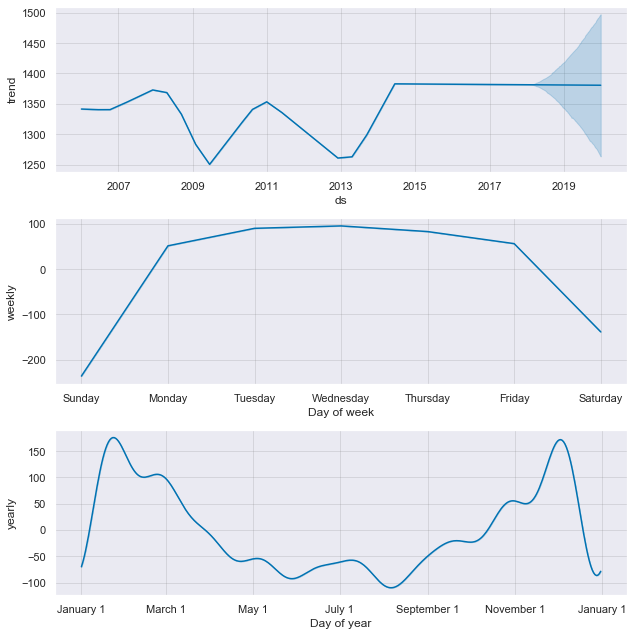

In [48]:
model.plot_components(forecast);